In [1]:
import sys
import numpy as np
from numpy import mean
from numpy import std

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# Add parent directory to path to allow import of config.py
sys.path.append("..")

import config as conf

First modeling strategy attempted will be a simple linear model which predicts the next term's enrollment based on all of the previous term's data.

In [2]:
data = pd.read_csv(f'{conf.DATA_PATH}{conf.FORMATTED_DATAFILE}')

# Seperate independent & dependent variables
X = data.drop('Next Semester Census Enrollment', axis=1)
y = data['Next Semester Census Enrollment']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Census Enrollment                14 non-null     float64
 1   Census Fill Rate                 14 non-null     float64
 2   Count of Migrated Data           14 non-null     float64
 3   Current Enrollment               14 non-null     float64
 4   Current Fill Rate                14 non-null     float64
 5   Enrollment Capacity              14 non-null     float64
 6   Ftef                             14 non-null     float64
 7   Ftes                             14 non-null     float64
 8   Ftes/Ftef                        14 non-null     float64
 9   Number Retained                  14 non-null     float64
 10  Number Successful                14 non-null     float64
 11  Retention Rate                   14 non-null     float64
 12  Sec. Count              

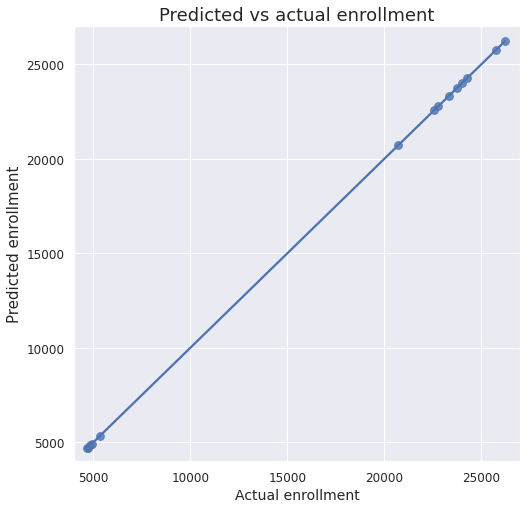

In [3]:
# Create and fit a LinearRegression object
lm = LinearRegression()
linear_model = lm.fit(X, y)

# Predict enrollment
predicted_enrollment = lm.predict(X)

# Grab actual enrollment numbers to compare with
actual_enrollment = y

# Plot actual enrollment vs predicted enrollment
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.regplot(y=predicted_enrollment, x=actual_enrollment, fit_reg=True, scatter_kws={'s':60})
ax.tick_params(labelsize=12)
ax.set_title('Predicted vs actual enrollment', fontsize=18)
ax.set_xlabel('Actual enrollment', fontsize=14)
ax.set_ylabel('Predicted enrollment', fontsize=15)
#ax.set_aspect('equal', 'box')
ax.set_xlim(4000, 27000)
ax.set_ylim(4000, 27000)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [4]:
scikit_R_sqr = linear_model.score(X, actual_enrollment)
print('SciKit-learn R\u00b2: {}'.format(np.round(scikit_R_sqr, 3)))

SciKit-learn R²: 1.0


In [7]:
# Instantiate base bagging model using linear regression
bagging_model = BaggingRegressor(
    LinearRegression(),
    n_estimators=50,
    max_samples=7,
    n_jobs=8,
    random_state=123
)

# Setup and k-fold cross validation
cv = RepeatedKFold(
    n_splits=2,
    n_repeats=500,
    random_state=1
)

# Score model
n_scores = cross_val_score(bagging_model, X, y, cv=cv, scoring='neg_mean_absolute_error')
MAEs = abs(n_scores)

# Report average performance
print('MAE: %.3f (%.3f)' % (abs(mean(n_scores)), std(n_scores)))

MAE: 13686.136 (9767.583)


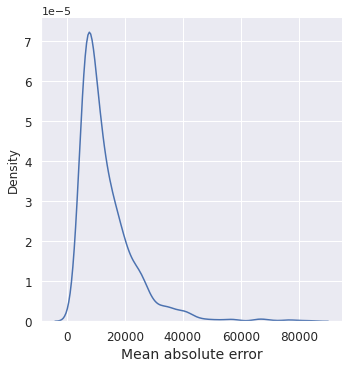

In [8]:
# Plot distribution of MAE scores from each k-fold
sns.displot(MAEs, kind="kde")
plt.tick_params(labelsize=12)
plt.xlabel('Mean absolute error', fontsize=14)

plt.show()

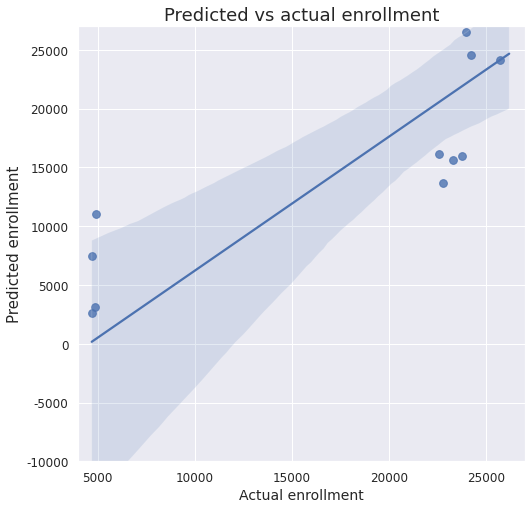

In [9]:
# Fit the model on the whole dataset
bagging_model.fit(X, y)

# Predict
predicted_enrollment = bagging_model.predict(X)

# Plot actual enrollment vs predicted enrollment
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.regplot(y=predicted_enrollment, x=actual_enrollment, fit_reg=True, scatter_kws={'s':60})
ax.tick_params(labelsize=12)
ax.set_title('Predicted vs actual enrollment', fontsize=18)
ax.set_xlabel('Actual enrollment', fontsize=14)
ax.set_ylabel('Predicted enrollment', fontsize=15)
ax.set_xlim(4000, 27000)
ax.set_ylim(-10000, 27000)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))